In [147]:
# Load all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import os
import requests
import urllib.request
import IPython.display as display
from sklearn.preprocessing import StandardScaler
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [148]:
# Define file paths
data_dir = "../project1"
hurricane_nc_path = os.path.join(data_dir, "IBTrACS.NA.v04r00.nc")
enso_path = os.path.join(data_dir, "enso_data.txt")

# Ensure the data directory exists
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download IBTrACS Hurricane Data if not found
ibtracs_url = "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc"

if not os.path.exists(hurricane_nc_path):
    print("Downloading IBTrACS hurricane data...")
    try:
        response = requests.get(ibtracs_url, timeout=60)
        response.raise_for_status()  # Raise an error if the request failed
        with open(hurricane_nc_path, "wb") as f:
            f.write(response.content)
        print("IBTrACS file downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")

# Load NetCDF hurricane data
try:
    ds = xr.open_dataset(hurricane_nc_path)
except Exception as e:
    print(f"Request failed: {e}")

# Convert NetCDF dataset to Pandas DataFrame
df_hurricane = ds.to_dataframe().reset_index()

# Select relevant columns based on dataset structure
df_hurricane = df_hurricane.loc[:, ["sid", "season", "time", "lat", "lon", "usa_wind"]].copy()

# Rename columns for clarity
df_hurricane.columns = ["Storm_ID", "Year", "ISO_Time", "Latitude", "Longitude", "Storm_Intensity"]

# Decode `sid` from bytes to string
df_hurricane["Storm_ID"] = df_hurricane["Storm_ID"].str.decode("utf-8")

# Convert Year to integer (from float)
df_hurricane["Year"] = df_hurricane["Year"].astype(int)

# Filter years from 1950 onwards
df_hurricane = df_hurricane[df_hurricane["Year"] >= 1950]

# Convert `ISO_Time` to datetime format
df_hurricane["ISO_Time"] = pd.to_datetime(df_hurricane["ISO_Time"], errors="coerce")

# Drop rows where conversion failed
df_hurricane = df_hurricane.dropna(subset=["ISO_Time"])

# Extract Month safely
df_hurricane["Month"] = df_hurricane["ISO_Time"].dt.month.astype(int)

# Convert Month from number to text for merging with ENSO
month_map = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}
df_hurricane["Month"] = df_hurricane["Month"].map(month_map)

# Define hurricane category mapping (based on wind speed in knots)
def categorize_hurricane(wind_speed):
    if wind_speed < 64:
        return "Tropical Storm"
    elif 64 <= wind_speed <= 82:
        return "Category 1"
    elif 83 <= wind_speed <= 95:
        return "Category 2"
    elif 96 <= wind_speed <= 112:
        return "Category 3"
    elif 113 <= wind_speed <= 136:
        return "Category 4"
    else:
        return "Category 5"

# Apply category mapping
df_hurricane["Category"] = df_hurricane["Storm_Intensity"].apply(categorize_hurricane)

# Save the cleaned dataset
df_hurricane.to_csv("../project1/hurricane_cleaned.csv", index=False)


In [149]:
#Cleaning ENSO table

# Load ENSO data
df_enso = pd.read_csv(enso_path, sep=r'\s+', header=None)

# Rename columns
df_enso.columns = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Remove non-numeric rows (e.g., headers, footers)
df_enso = df_enso[df_enso["Year"].astype(str).str.match(r'^\d{4}$')]

# Convert Year to integer
df_enso["Year"] = df_enso["Year"].astype(int)

# Convert to long format
df_enso_long = df_enso.melt(id_vars=["Year"], var_name="Month", value_name="SST_Anomaly")

# Convert SST_Anomaly to numeric
df_enso_long["SST_Anomaly"] = pd.to_numeric(df_enso_long["SST_Anomaly"], errors="coerce")

# Sort values (important for applying 5-month rule)
df_enso_long = df_enso_long.sort_values(by=["Year", "Month"]).reset_index(drop=True)

# Initialize ENSO phase column
df_enso_long["ENSO_Phase"] = "Neutral"

# Function to apply 5-month rule
def detect_enso_events(df):
    consecutive_count = 0
    current_phase = "Neutral"
    
    for i in range(len(df)):
        anomaly = df.loc[i, "SST_Anomaly"]

        # Determine the phase for this month
        if anomaly >= 0.5:
            phase = "El Niño"
        elif anomaly <= -0.5:
            phase = "La Niña"
        else:
            phase = "Neutral"

        # If we are continuing the same phase, increase count
        if phase == current_phase:
            consecutive_count += 1
        else:
            # If we switch phases, reset the counter
            consecutive_count = 1
            current_phase = phase

        # If phase has lasted for at least 5 months, apply to previous months
        if consecutive_count >= 5:
            for j in range(i - 4, i + 1):
                df.loc[j, "ENSO_Phase"] = current_phase  # Apply to previous 5 months

    return df

# Apply 5-month rule
df_enso_long = detect_enso_events(df_enso_long)
df_enso_long.to_csv("../project1/enso_cleaned.csv", index=False)
df_enso_long

,Year,Month,SST_Anomaly,ENSO_Phase
0,1870,Apr,-0.81,La Niña
1,1870,Aug,-0.88,La Niña
2,1870,Dec,-0.79,La Niña
3,1870,Feb,-1.20,La Niña
4,1870,Jan,-1.00,La Niña
...,...,...,...,...
1843,2023,Mar,-0.13,Neutral
1844,2023,May,0.47,Neutral
1845,2023,Nov,2.01,Neutral
1846,2023,Oct,1.59,Neutral


In [150]:
#merge ENSO and hurricane data together
df_hurricane["Year"] = df_hurricane["Year"].astype(int)
df_hurricane["Month"] = df_hurricane["Month"].astype(str)

df_enso_long["Year"] = df_enso_long["Year"].astype(int)
df_enso_long["Month"] = df_enso_long["Month"].astype(str)
df_enso_long = df_enso_long[df_enso_long["Year"] >= 1950]

# Define a dictionary to map abbreviated month names to full names
month_map = {
    "Jan": "January", "Feb": "February", "Mar": "March", "Apr": "April", "May": "May", "Jun": "June",
    "Jul": "July", "Aug": "August", "Sep": "September", "Oct": "October", "Nov": "November", "Dec": "December"
}

# Apply the mapping
df_hurricane["Month"] = df_hurricane["Month"].map(month_map)
df_enso_long.loc[:, "Month"] = df_enso_long["Month"].map(month_map)

# Ensure all Month values are consistent by stripping spaces
df_hurricane["Month"] = df_hurricane["Month"].str.strip()
df_enso_long.loc[:, "Month"] = df_enso_long["Month"].str.strip()

# Convert to lowercase (optional but helps prevent mismatches)
df_hurricane["Month"] = df_hurricane["Month"].str.capitalize()
df_enso_long.loc[:, "Month"] = df_enso_long["Month"].str.capitalize()
df_hurricane = df_hurricane[df_hurricane["Year"] >= 1950]

# Merge hurricane data with ENSO data on Year & Month
df_merged_ENSO = df_hurricane.merge(df_enso_long, on=["Year", "Month"], how="left")

# Save merged dataset
df_merged_ENSO.to_csv("../project1/merged_enso.csv", index=False)

df_merged_ENSO


,Storm_ID,Year,ISO_Time,Latitude,Longitude,Storm_Intensity,Month,Category,SST_Anomaly,ENSO_Phase
0,1950224N17305,1950,1950-08-12 00:00:00.000040448,17.100000,-55.500000,35.0,August,Tropical Storm,-0.63,La Niña
1,1950224N17305,1950,1950-08-12 00:00:00.000040448,17.100000,-55.500000,35.0,August,Tropical Storm,-0.63,La Niña
2,1950224N17305,1950,1950-08-12 00:00:00.000040448,17.100000,-55.500000,35.0,August,Tropical Storm,-0.63,La Niña
3,1950224N17305,1950,1950-08-12 00:00:00.000040448,17.100000,-55.500000,35.0,August,Tropical Storm,-0.63,La Niña
4,1950224N17305,1950,1950-08-12 03:00:00.000040448,17.417561,-55.872150,37.0,August,Tropical Storm,-0.63,La Niña
...,...,...,...,...,...,...,...,...,...,...
258355,2023321N15278,2023,2023-11-17 21:00:00.000039936,18.596569,-77.843597,30.0,November,Tropical Storm,2.01,Neutral
258356,2023321N15278,2023,2023-11-18 00:00:00.000039936,19.250000,-77.199997,30.0,November,Tropical Storm,2.01,Neutral
258357,2023321N15278,2023,2023-11-18 00:00:00.000039936,19.250000,-77.199997,30.0,November,Tropical Storm,2.01,Neutral
258358,2023321N15278,2023,2023-11-18 00:00:00.000039936,19.250000,-77.199997,30.0,November,Tropical Storm,2.01,Neutral


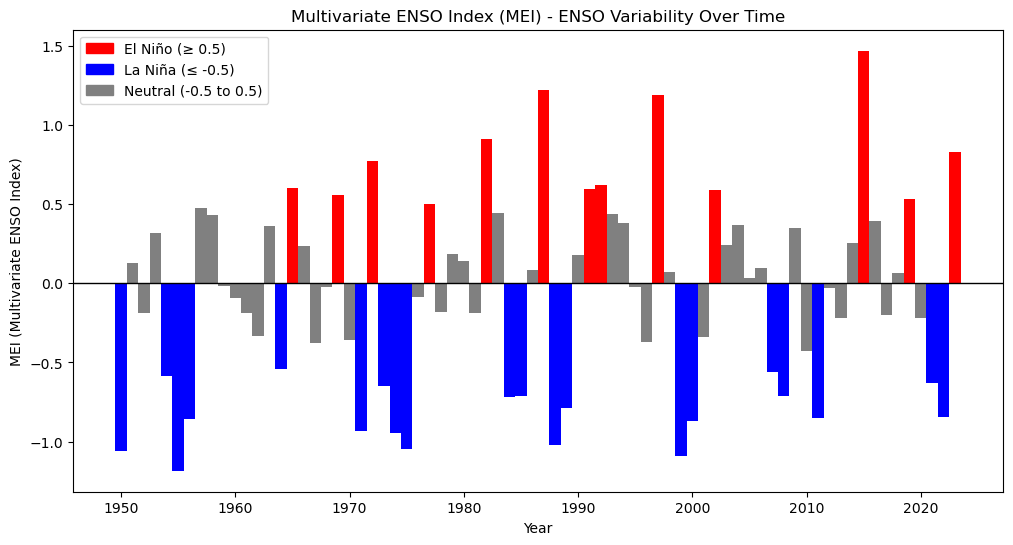

In [151]:
#ENSO Visualization of La Nina and El Nino years

# Aggregate by Year (Average SST anomaly per year)
df_yearly = df_enso_long.groupby("Year")["SST_Anomaly"].mean().reset_index()

# Classify ENSO Phase for yearly data
def classify_enso(value):
    if value >= 0.5:
        return "El Niño"
    elif value <= -0.5:
        return "La Niña"
    else:
        return "Neutral"

df_yearly["ENSO_Phase"] = df_yearly["SST_Anomaly"].apply(classify_enso)

# Set figure size
plt.figure(figsize=(12, 6))

# Plot positive bars for El Niño (Red)
plt.bar(df_yearly["Year"], df_yearly["SST_Anomaly"], color=df_yearly["SST_Anomaly"].apply(lambda x: "red" if x >= 0.5 else "blue" if x <= -0.5 else "gray"), width=1.0)

# Add a horizontal line at y=0
plt.axhline(0, color="black", linewidth=1)

# Labels and title
plt.xlabel("Year")
plt.ylabel("MEI (Multivariate ENSO Index)")
plt.title("Multivariate ENSO Index (MEI) - ENSO Variability Over Time")

# Add a legend for ENSO phases
legend_labels = [
    mpatches.Patch(color="red", label="El Niño (≥ 0.5)"),
    mpatches.Patch(color="blue", label="La Niña (≤ -0.5)"),
    mpatches.Patch(color="gray", label="Neutral (-0.5 to 0.5)")
]
plt.legend(handles=legend_labels, loc="upper left")


# Show the plot
plt.show()


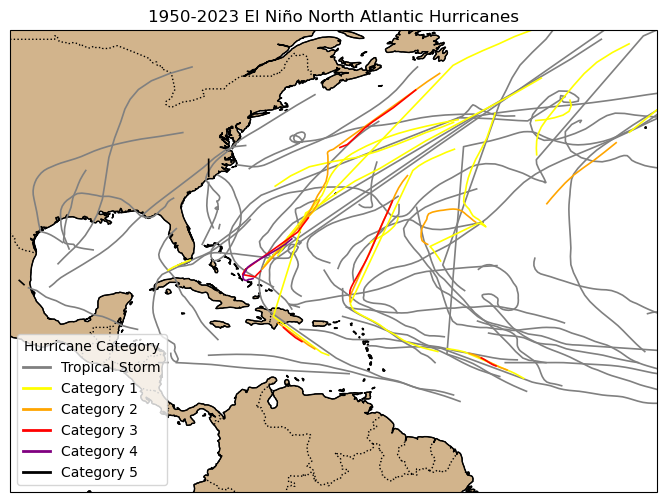

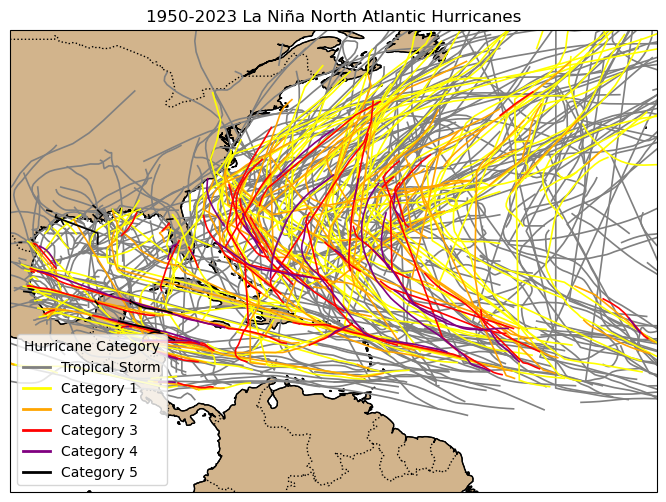

In [152]:
# Visualize hurricane tracks for El Niño and La Niña years

# Function to create a map with background
def map_background(extent, title):
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 8))
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add features (land, coastlines, etc.)
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False

    # Add title
    plt.title(title, fontsize=14, fontweight="bold")

    return ax

# Define function to plot hurricane tracks based on category
def plot_hurricane_tracks(df, title):
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

    # Set up map with coastlines
    ax.set_extent([-100, -30, 0, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="tan")

    # Define category colors
    category_colors = {
        "Tropical Storm": "gray",
        "Category 1": "yellow",
        "Category 2": "orange",
        "Category 3": "red",
        "Category 4": "purple",
        "Category 5": "black"
    }

    # Plot hurricane tracks, color-coded by category
    for cat, color in category_colors.items():
        subset = df[df["Category"] == cat]
        for storm_id in subset["Storm_ID"].unique():
            storm_data = subset[subset["Storm_ID"] == storm_id]
            ax.plot(storm_data["Longitude"], storm_data["Latitude"], 
                    linestyle="-", linewidth=1.2, color=color, label=cat if storm_id == subset["Storm_ID"].unique()[0] else "")

    # Add legend
    handles = [plt.Line2D([0], [0], color=color, linewidth=2, label=cat) for cat, color in category_colors.items()]
    ax.legend(handles=handles, loc="lower left", title="Hurricane Category")

    # Add title
    plt.title(title)

    # Show plot
    plt.show()


# El Niño Hurricane Tracks
df_nino = df_merged_ENSO[df_merged_ENSO["ENSO_Phase"] == "El Niño"]
plot_hurricane_tracks(df_nino, "1950-2023 El Niño North Atlantic Hurricanes")

# La Niña Hurricane Tracks
df_nina = df_merged_ENSO[df_merged_ENSO["ENSO_Phase"] == "La Niña"]
plot_hurricane_tracks(df_nina, "1950-2023 La Niña North Atlantic Hurricanes")



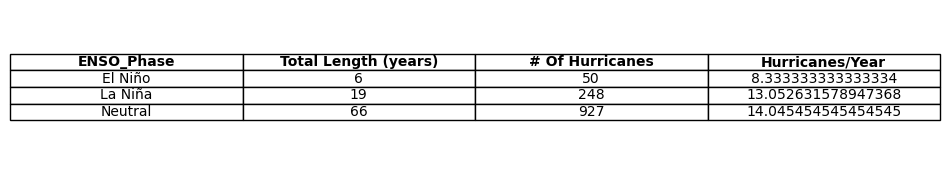

In [153]:
#Frequency of hurricanes during different ENSO stages

# Ensure ENSO Phase is categorized correctly
df_merged_ENSO["ENSO_Phase"] = df_merged_ENSO["ENSO_Phase"].astype(str)

# Total length (years) per ENSO Phase
total_years = df_merged_ENSO.groupby("ENSO_Phase")["Year"].nunique()

# Number of unique hurricanes per ENSO Phase
num_hurricanes = df_merged_ENSO.groupby("ENSO_Phase")["Storm_ID"].nunique()

# Hurricanes per year per ENSO Phase
hurricanes_per_year = num_hurricanes / total_years

# Combine into a DataFrame
enso_summary = pd.DataFrame({
    "Total Length (years)": total_years,
    "# Of Hurricanes": num_hurricanes,
    "Hurricanes/Year": hurricanes_per_year
})

# Reset index for better readability
enso_summary = enso_summary.reset_index()

# Display the summary table
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=enso_summary.values, colLabels=enso_summary.columns, cellLoc='center', loc='center')

# Formatting the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold')

# Show the table
plt.show()


In [155]:
#Function to calculate moment for a storm

def get_first_moment(df):
    """Computes the first moment (mean latitude & longitude) of a hurricane track."""
    if df.empty:
        return None  # Handle empty cases

    mean_lat = df["Latitude"].mean()
    mean_lon = df["Longitude"].mean()
    return [mean_lon, mean_lat]  # Longitude first for mapping consistency

# Compute first moments for each unique hurricane track
moment_lst = [get_first_moment(df_merged_ENSO[df_merged_ENSO["Storm_ID"] == storm])
              for storm in df_merged_ENSO["Storm_ID"].unique()]

# Remove any None values (cases where hurricanes had missing data)
moment_lst = [m for m in moment_lst if m is not None]

# Convert to NumPy array for clustering
moment_arr = np.array(moment_lst)

print(f"Computed first moments for {len(moment_arr)} hurricane tracks.")

Computed first moments for 1195 hurricane tracks.


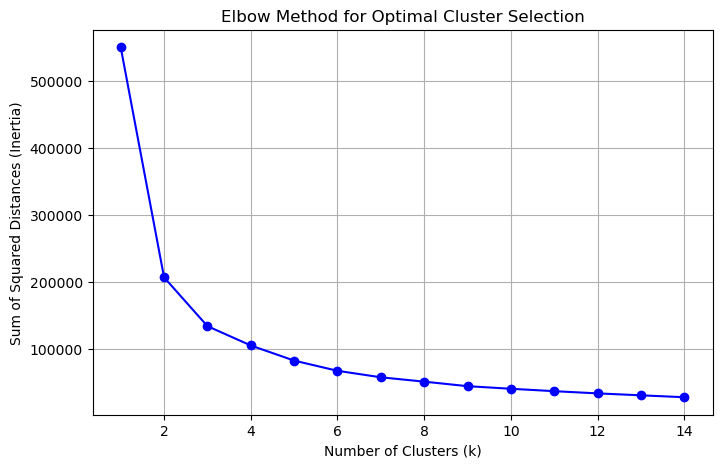

In [156]:
#Find number of clusters using Elbow-Method

# Initialize a list to store sum of squared distances (inertia)
sum_of_squares = []
K_range = range(1, 15)  # Testing K from 1 to 14

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(moment_arr)
    sum_of_squares.append(kmeans.inertia_)  # Store inertia value

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, sum_of_squares, 'bo-', markersize=6)  # Blue circles with a line
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method for Optimal Cluster Selection')
plt.grid()
plt.show()


<Figure size 1000x600 with 0 Axes>

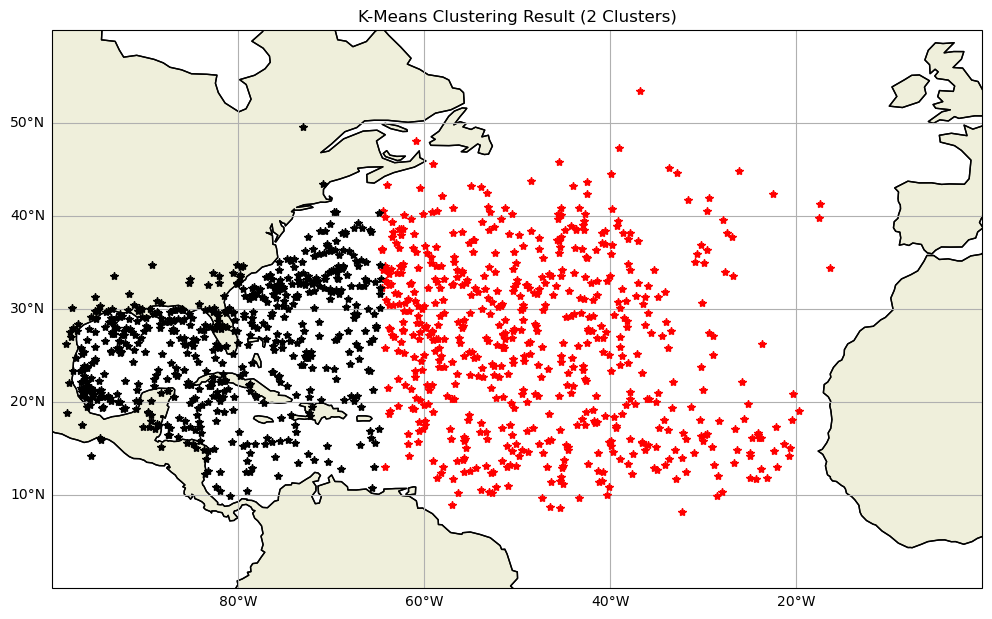

In [158]:
#K-clustering of ENSO's impact on hurricanes

# Define map extent (adjust if needed)
extent = [-100, 0, 0, 60]  # Longitude and Latitude bounds

# Define optimal k from elbow method
optimal_k = 2  # Change this based on the elbow method result

# Apply K-Means clustering to first-moment hurricane tracks
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(moment_lst)

# Define cluster colors (extend list if more clusters are needed)
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']

# Plot first-moment clustering results
plt.figure(figsize=(10, 6))
ax = map_background(extent, title="K-Means Clustering of Hurricane Tracks")

# Plot each cluster with assigned color
for i, moment in enumerate(moment_lst):
    ax.plot(moment[0], moment[1], c=colors[labels[i]], marker='*')

plt.title(f'K-Means Clustering Result ({optimal_k} Clusters)')
plt.show()



In [ ]:
#Merge AMO data with Hurricane NA Basin data

#Load AMO data
amo_path = "../project1/csu_amo.csv"
df_amo = pd.read_csv(amo_path)

#Filter Hurricane data to start at 1950
df_hurricane = df_hurricane[df_hurricane["Year"] >= 1950]

# Convert AMO data to long format
df_amo_long = df_amo.melt(id_vars=["Year"], var_name="Month", value_name="AMO_Anomaly")

# Ensure Month names match the hurricane dataset
month_map = {
    "Jan": "January", "Feb": "February", "Mar": "March", "Apr": "April", "May": "May", "Jun": "June",
    "Jul": "July", "Aug": "August", "Sep": "September", "Oct": "October", "Nov": "November", "Dec": "December"
}
df_amo_long["Month"] = df_amo_long["Month"].map(month_map)

# Convert data types to match hurricane dataset
df_amo_long["Year"] = df_amo_long["Year"].astype(int)
df_amo_long["Month"] = df_amo_long["Month"].astype(str)

print(df_amo_long.head())  # Check transformed data

df_merge_amo = df_hurricane.merge(df_amo_long, on=["Year", "Month"], how="left")

# Save merged dataset
df_merge_amo.to_csv("../project1/merged_amo.csv", index=False)
